In [124]:
import seaborn as sns
import json
import pandas as pd
import numpy as np


def load_data(file: str, label: str, other: bool):
    maps = {}
    syms = {}
    has_syms = False
    with open(file) as f:
        for line in f:
            if line.startswith("{"):
                x = json.loads(line)
                if x.get("type") == "map" and x.get("data", {}) is not None:
                    for k, v in x.get("data").items():
                        maps[k] = v
                if x.get("type") == "printf" and (x["data"].startswith("U ") or x["data"].startswith("K ")):
                    raw: str = x["data"].strip()[2:]
                    addr, sym = raw.split("@", 1)
                    syms[int(addr, 16)] = sym
                    has_syms = True
    map = maps["@instr_samples"] if not other else maps["@instr_samples_other"]

    cacheline_count: dict[str, int] = {}
    for k, v in map.items():
        addr = int(k, 16)
        cacheline = f"0x{(addr >> 6) << 6:x}"

        cacheline_count[cacheline] = cacheline_count.get(cacheline, 0) + v

    entries = [(k, v) for k, v in cacheline_count.items()]
    entries.sort(key=lambda x: x[1], reverse=True)
    total_samples = sum(x[1] for x in entries)
    total_instructions = len(map)
    total_cachelines = len(cacheline_count)
    print(f"[{label}] Total samples: {total_samples}, Total instructions: {total_instructions}, Total cachelines: {total_cachelines}")
    entries_w_index = [(float(i + 1) / len(entries), x[0], x[1]) for i, x in enumerate(entries)]
    entries_cumu = []
    s = 0
    for i, x in enumerate(entries_w_index):
        s += x[2]
        entries_cumu.append((x[0], x[1], x[2], s))  # (index, ipaddr, samples, samples.cumulative)
    entries_cumu_norm = [(x[0], x[1], x[2], x[3], x[2] / total_samples, x[3] / total_samples) for x in entries_cumu]
    if has_syms:
        entries_cumu_norm_syms = [(x[0], x[1], x[2], x[3], x[4], x[5], syms.get(int(x[1], 16), "?")) for x in entries_cumu_norm]
        for x in entries_cumu_norm_syms:
            if syms.get(x[1], "?") != "?":
                print(x[1], syms.get(x[1], "?"))
        df = pd.DataFrame(entries_cumu_norm_syms, columns=["cacheline", "cacheline.addr", "samples", "samples.cumu", "samples.norm", "samples.cumu.norm", "symbol"])
    else:
        df = pd.DataFrame(entries_cumu_norm, columns=["cacheline", "cacheline.addr", "samples", "samples.cumu", "samples.norm", "samples.cumu.norm"])
    # print(df)
    return df


def plot(**files: str):
    dfs = []
    for k, v in files.items():
        if k.endswith("other"):
            df = load_data(v, label=k, other=True)
        else:
            df = load_data(v, label=k, other=False)
        df["gc"] = k
        dfs.append(df)
    df = pd.concat(dfs)

    g = sns.lineplot(data=df, x="cacheline", y="samples.cumu.norm", hue="gc")

    if g.axes:
        g.axes.grid(True, axis="both")

    # g.set_xticks(np.arange(0, 1.1, 0.1))
    g.set_yticks(np.arange(0, 1.1, 0.1))

    # Find intersections
    points = []
    Y = 0.95
    x = np.interp(Y, df[df["gc"] == "g1"]["samples.cumu.norm"], df[df["gc"] == "g1"]["cacheline"])
    points.append(("g1", x, Y))
    x = np.interp(Y, df[df["gc"] == "lxr"]["samples.cumu.norm"], df[df["gc"] == "lxr"]["cacheline"])
    points.append(("lxr", x, Y))
    x = np.interp(Y, df[df["gc"] == "ix"]["samples.cumu.norm"], df[df["gc"] == "ix"]["cacheline"])
    points.append(("ix", x, Y))

    X = 0.05
    y = np.interp(X, df[df["gc"] == "g1"]["cacheline"], df[df["gc"] == "g1"]["samples.cumu.norm"])
    points.append(("g1", X, y))
    y = np.interp(X, df[df["gc"] == "lxr"]["cacheline"], df[df["gc"] == "lxr"]["samples.cumu.norm"])
    points.append(("lxr", X, y))
    y = np.interp(X, df[df["gc"] == "ix"]["cacheline"], df[df["gc"] == "ix"]["samples.cumu.norm"])
    points.append(("ix", X, y))

    print(points)

    g.axhline(y=0.95, linewidth=2, color="grey", ls=":")
    g.axvline(x=0.05, linewidth=2, color="grey", ls=":")

    g.annotate("0.05", xy=(0.05, 0.1), xytext=(0, -30), fontsize=10, textcoords="offset points", ha="center", va="center", color="grey")
    g.annotate("0.95", xy=(0.001, 0.95), xytext=(-130, 0), fontsize=10, textcoords="offset points", ha="center", va="center", color="grey")

    colors = sns.color_palette()
    keys = list(files.keys())
    for gc, x, y in points:
        index = keys.index(gc)
        color = colors[index]
        # g.annotate(gc, (x, y), textcoords="offset points", xytext=(0, 10), ha="center")
        # Plot the intersection points
        g.plot(x, y, "ro", color=color)
        coord = f"({x:.2f}, {y:.2f})"
        arrowprops = dict(arrowstyle="->", color=color)

        def annotate(tx, ty, arrow=None):
            if arrow is not None:
                g.annotate(coord, xy=(x, y), xytext=(tx, ty), fontsize=10, textcoords="offset points", ha="center", va="center", color=color, arrowprops=arrowprops)
            else:
                g.annotate(coord, xy=(x, y), xytext=(tx, ty), fontsize=10, textcoords="offset points", ha="center", va="center", color=color)

        # Manually set annotation positions
        if x < 0.04:
            annotate(-30, 10)
        elif x > 0.055:
            if gc == "g1":
                annotate(40, 30, arrow=True)
            else:
                annotate(50, -20, arrow=True)
        elif y > 0.97:
            annotate(-20, 10)
        elif y < 0.93:
            annotate(-10, -50, arrow=True)
        elif y > 0.93:
            annotate(-70, -10, arrow=True)
        else:
            raise ValueError(f"Unknown position {gc} {x} {y}")

    g.set_xscale("log")
    g.set_xticklabels(["0.00001", "0.0001", "0.001", "0.01", "0.1", "1"])
    sns.set_theme(rc={"figure.figsize": (11, 5)})
    g.get_figure().savefig("hotness.pdf")  # type: ignore

    return df

[g1] Total samples: 10235384, Total instructions: 15573, Total cachelines: 3545
[ix] Total samples: 21143168, Total instructions: 12298, Total cachelines: 3372
[lxr] Total samples: 3590639, Total instructions: 11136, Total cachelines: 3100
[('g1', 0.06468909220265358, 0.95), ('lxr', 0.05852933606827016, 0.95), ('ix', 0.011232905293898797, 0.95), ('g1', 0.05, 0.9247142559575684), ('lxr', 0.05, 0.9352583203156876), ('ix', 0.05, 0.9906580887026959)]


/tmp/ipykernel_641471/565708004.py:109: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  g.plot(x, y, "ro", color=color)
/tmp/ipykernel_641471/565708004.py:137: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(["0.00001", "0.0001", "0.001", "0.01", "0.1", "1"])


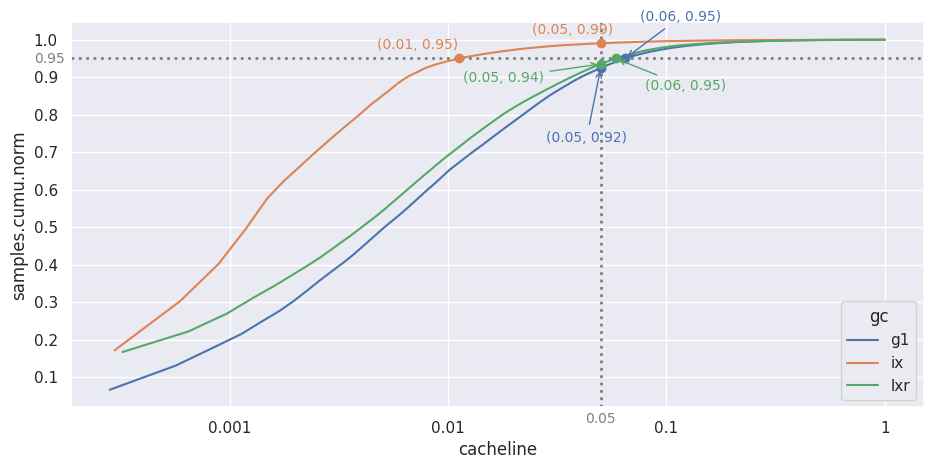

In [125]:
_ = plot(
    g1="../../h2-g1.jsonl",
    ix="../../h2-ix.jsonl",
    lxr="../../h2-lxr.jsonl",
)